In [386]:

!pip install -q tfds-nightly




You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [387]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [388]:

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']



In [389]:
one_pt,one_en=next(iter(train_examples))

In [390]:
# 这个类库不知道为啥我用不了，我换成tokenizer了
# 这个的功能除了分词，当遇到oov的时候相当于把词做切分了，比如Transformer就可能变成Trans和fromer两个词
# The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

AttributeError: module 'tensorflow_datasets' has no attribute 'deprecated'

In [391]:
# 只保留2**13个词 八千多
tokenizer_en=tf.keras.preprocessing.text.Tokenizer(num_words=2**13,oov_token="<UNK>")
tokenizer_en.fit_on_texts([en.numpy().decode('utf-8') for pt, en in train_examples])
tokenizer_pt=tf.keras.preprocessing.text.Tokenizer(num_words=2**13,oov_token="<UNK>")
tokenizer_pt.fit_on_texts([pt.numpy().decode('utf-8') for pt, en in train_examples])

In [392]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.texts_to_sequences([sample_string])
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.sequences_to_texts(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [[1, 13, 1694]]
The original string: ['<UNK> is awesome']


In [393]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def encode(lang1, lang2):
  # 与官网不同，我做了修改，使用的是tokenizer
  lang1 = [2**13] + tokenizer_pt.texts_to_sequences(
      [lang1.numpy().decode("utf8")])[0] + [2**13+1]

  lang2 = [2**13] + tokenizer_en.texts_to_sequences(
      [lang2.numpy().decode("utf8")])[0] + [2**13+1]

  return lang1, lang2

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

encode(one_pt,one_en)

([8192, 5, 35, 1, 2, 761, 3901, 2, 358, 2257, 18, 1702, 4, 8, 2, 1, 8193],
 [8192,
  3,
  53,
  12,
  1085,
  1,
  12,
  86,
  117,
  237,
  2,
  39,
  2009,
  5,
  2286,
  84,
  13,
  1,
  8193])

In [394]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)


In [395]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 39), dtype=int64, numpy=
 array([[8192,  282, 7964, ...,    0,    0,    0],
        [8192,   87,  136, ...,    0,    0,    0],
        [8192, 4239,    9, ...,    0,    0,    0],
        ...,
        [8192,   87,    2, ...,    0,    0,    0],
        [8192,   26, 7434, ...,    0,    0,    0],
        [8192,   21, 1247, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8192,   85,   18, ...,    0,    0,    0],
        [8192,    8,   19, ...,    0,    0,    0],
        [8192,    8, 2251, ...,    0,    0,    0],
        ...,
        [8192,    9,   19, ...,    0,    0,    0],
        [8192,    8, 1562, ...,    0,    0,    0],
        [8192,  941,   10, ...,    0,    0,    0]])>)

In [396]:
# tokenizer_pt.word_docs

In [397]:
"""
终于通过代码看懂了Positional encoding是个啥
相当于对位置信息进行embedding，假如说有一个长度为50的序列，那么对这个序列的每个位置进行编码，假如需要的维度为512
对于其第pos个位置（例如第0个位置，pos就是0），先计算一个pos/10000^{2*i/512}的向量，i从0一直到511，所以这是一个512维度的向量
然后如果这个pos是一个奇数，就对其计算cos，否则计算sin
最终的position encoding就是一个50*512的向量
"""

def get_angles(pos, i, d_model):
  print(pos.shape)
  print(i.shape)
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  print(angle_rates.shape)
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  print(angle_rads.shape)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, 512)
print (pos_encoding)

(50, 1)
(1, 512)
(1, 512)
(50, 512)
tf.Tensor(
[[[ 0.          1.          0.         ...  1.          0.
    1.        ]
  [ 0.84147096  0.5403023   0.8218562  ...  1.          0.00010366
    1.        ]
  [ 0.9092974  -0.41614684  0.9364147  ...  1.          0.00020733
    1.        ]
  ...
  [ 0.12357312 -0.9923355   0.97718984 ...  0.99998724  0.00487216
    0.99998814]
  [-0.76825464 -0.64014435  0.7312359  ...  0.9999867   0.00497582
    0.9999876 ]
  [-0.95375264  0.30059254 -0.14402692 ...  0.9999861   0.00507948
    0.9999871 ]]], shape=(1, 50, 512), dtype=float32)


In [398]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [399]:
def create_look_ahead_mask(size):
  # 这是个有趣的api，相当于对一个矩阵斜着进行遮罩
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [400]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.
  这代码写得真好，看明白了，mask的形状不定，只要能与(..., seq_len_q, seq_len_k)相加就好了
  Returns:
    output, attention_weights
  """
  # q和k的最后两维度被当做矩阵进行相乘
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    # 当mask为1的地方，这个attention是无限小的，而由于激活函数是relu，所以导致这些地方的输出也是0，从而保证未来的词或者padding词不会对之前的信息产生影响
    # 并且反向传播传递不回去，不会对之前的0位置产生梯度
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [401]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)
  
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

print("牛逼")

# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
print("牛逼")

# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
print("牛逼")

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
牛逼
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
牛逼
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
牛逼


In [402]:
mask=tf.constant([[[[0,1]]],[[[1,0]]]],dtype=tf.float32)
print(mask.shape)
tf.zeros((2,2,3,2))+mask
# scaled_attention_logits += (mask * -1e9)

# temp_k = tf.constant([[10,0,0],
#                       [0,10,0],
#                       [0,0,10],
#                       [0,0,10]], dtype=tf.float32)  # (4, 3)
#
# temp_v = tf.constant([[   1,0],
#                       [  10,0],
#                       [ 100,5],
#                       [1000,6]], dtype=tf.float32)  # (4, 2)
#
# # This `query` aligns with the second `key`,
# # so the second `value` is returned.
# temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
#
# temp_out, temp_attn = scaled_dot_product_attention(
#       temp_k, temp_v, temp_q, [])
# print ('Attention weights are:')
# print (temp_attn)
# print ('Output is:')
# print (temp_out)

(2, 1, 1, 2)


<tf.Tensor: shape=(2, 2, 3, 2), dtype=float32, numpy=
array([[[[0., 1.],
         [0., 1.],
         [0., 1.]],

        [[0., 1.],
         [0., 1.],
         [0., 1.]]],


       [[[1., 0.],
         [1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.]]]], dtype=float32)>

In [403]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)

    这个玩意的功能就比如说，输入的是(batch_size,seq_len,d_model)，然后把最后一个depth分割成(batch_size,num_heads,seq_len,depth)
    reshape的-1代表自动计算
    最后这个transpose就是为了把head挪到1轴去，通过学习transpose可知，这个操作就相当于把d_model切开了
    意义在于：结果的里每个head（最后两个维度对应的数据）保存的是全部sequence对应的全部d_model中的一块（就是一个head）
    不要去想具体是怎么转置的，维度高了想不明白的，只要知道就是轴变换就好
    """
    # print(x.shape)
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [404]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [405]:
y = tf.random.uniform((1, 3, 2))
out, attn = temp_mha(y, k=y, q=y, mask=[])
out.shape, attn.shape

InvalidArgumentError: Matrix size-incompatible: In[0]: [3,2], In[1]: [512,512] [Op:MatMul]

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])
sample_ffn = point_wise_feed_forward_network(512, 2048)
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)
sample_ffn.summary()


In [406]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    """

    :param x: tensor 形如[batch_size,seq_len,emb_size] 这里要求的emb_size就是d_model
    :param training:
    :param mask:
    :return:
    """
    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2


In [407]:
"""
这一段数据是怎么流动的，输入是形如batch_size,seq_len,emb_size
这个东西会喂给MultiHeadAttention做self attention，而由于split——head的存在，MultiHeadAttention会把输入进行处理
那么每个scale-dot-production的输入就是(batch_size,head_num,seq_len,seq_len)
计算出来的QK^T形状是(batch_size,head_num,seq_len,seq_len)
然后做mask，如果这个mask之后再说
这些个multiHeadAttention输出的结果也是一个(batch_size, seq_len, emb_size)
"""

sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)



TensorShape([64, 43, 512])

In [408]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # 这俩mask的实际应用就是在scaled_dot_product_attention里，给输出加了一点小扰动，为啥不知道
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [409]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)


TensorShape([64, 50, 512])

In [410]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # emb层的维度就是d_model
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model) #输出就是一个maximum_position_encoding*d_model的数组

    # 多个嵌入层
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # 为啥要乘以一个根号model呢？
    x += self.pos_encoding[:, :seq_len, :] #取出pos_encoding的需要用到的长度，也就是输入序列的长度

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask) # 多个嵌入层串联

    return x  # (batch_size, input_seq_len, d_model)


In [411]:
"""
这一段里的数据是怎么流动的

"""

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)



(10000, 1)
(1, 512)
(1, 512)
(10000, 512)
(64, 62, 512)


In [412]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      # 多个dec_layer也是串联，但是每个dec_layer都用到了enc的输出
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [413]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(5000, 1)
(1, 512)
(1, 512)
(5000, 512)


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [414]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights


In [415]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=2**13, # 这个我改了一下，因为我设置的词表大小是2**13
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


(10000, 1)
(1, 512)
(1, 512)
(10000, 512)
(6000, 1)
(1, 512)
(1, 512)
(6000, 512)


TensorShape([64, 36, 8192])

In [416]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

# input_vocab_size = tokenizer_pt.vocab_size + 2
input_vocab_size = 2**13 + 2
# target_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = 2**13 + 2
dropout_rate = 0.1

In [417]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [418]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

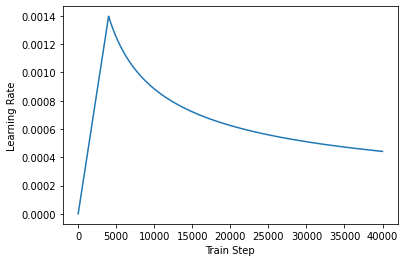

In [419]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [420]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [421]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)
def create_masks(inp, tar):
  # (batch_size, seq_len)
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp) # 这个功能就是找pading，是padding位置的就会是1，形状与输入相同

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) # 这个是一个(tf.shape(tar)[1],tf.shape(tar)[1])的方形数组
  dec_target_padding_mask = create_padding_mask(tar) #这是个(batch_size, 1, 1, seq_len)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # 这个的输出是(batch_size, 1, seq_len, seq_len)
  # 即会扩充
  """
  这些个musk是怎么使用的呢
  先举个小栗子
  比如说tar的其中一个序列是[1,2,2,0,0]
  那么look_ahead_mask就是一个[[0,1,1,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,0,1],[0,0,0,0,0]] seq_len,seq_len大小
  dec_target_padding_mask就是[0,0,0,1,1]，即确定padding位置
  于是combined_mask结果就是[[0,1,1,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,1,1],[0,0,0,1,1]]
  这是为了保证padding的位置不需要进行lookahead masking
  这些个mask会被直接送进各个scale dot production里
  
  这些东西怎么用呢
  以enc_padding_mask为例，在实际应用中，其形状为[batch_size,1,1,seq_len] 记为A。
  以encoder部分的multiheadattention为例，multiheadattention里scale dot product接受的是[batch_size,num_head,seq_len,depth]
  乘积项QK^T刚好也是一个形状[batch_size,num_head,seq_len,seq_len] 记为B
  B+A*-10^9的时候，会对A做broadcast，也就是说，假如A[0,0,0,10]=1，那么结果的[0,:,:,10]都等于一个很小的负数
  这样做的意义也出现了，就是不要去计算pad与其他词之间的self attention


  注意，combined_mask只在decode使用
  encoder只使用了padding_mask。因为encoding阶段不需要考虑look ahead啊
  combined_mask的形状是(batch_size,1,seq_len,seq_len)，而在scale dot里，QK^T是（batch_size,num_head,seq_len,seq_len)大小的
  两者刚好可以相加，与上面道理类似
  """
  return enc_padding_mask, combined_mask, dec_padding_mask

(8194, 1)
(1, 128)
(1, 128)
(8194, 128)
(8194, 1)
(1, 128)
(1, 128)
(8194, 128)


In [422]:
look_ahead_mask = create_look_ahead_mask(5)
dec_target_padding_mask = create_padding_mask([[1,2,2,0,0]]) #这是个(batch_size, 1, 1, seq_len)
combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
print(look_ahead_mask)
print(dec_target_padding_mask)
print(combined_mask)

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [423]:
tf.maximum(tf.reshape(tf.range(-5,5,dtype=tf.float32),(2,1,1,5)), create_look_ahead_mask(5))

<tf.Tensor: shape=(2, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]],


       [[[0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.]]]], dtype=float32)>

In [424]:
create_look_ahead_mask(5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [425]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [426]:
EPOCHS = 20
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  # print(enc_padding_mask)
  # print(combined_mask)
  # print(dec_padding_mask)
  # return
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    break
  break
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [344]:
inp_batch, tar_batch=next(iter(train_dataset))
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_batch, tar_batch)

In [345]:
"""
所以数据到底是怎么变的呢
输入数据是(batch_size,seq_len,)
"""



<tf.Tensor: shape=(64, 1, 1, 33), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 0., 0., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       ...,


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>

In [ ]:
combined_mask